# Import Libraries / Data

In [62]:
import pandas as pd 
import numpy as np
import PyPDF2

import spacy
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from sklearn.feature_extraction import text
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

import nltk
from nltk.text import Text

import networkx as nx
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import json #open saved tokens
from textblob import TextBlob #sentiment analysis



In [3]:
with open('data.json') as json_file:
    data = json.load(json_file)

# Functions 

In [27]:
def freq_bigram(tokens):
    bgs=nltk.bigrams(tokens)
    global fdist_bi
    fdist_bi = nltk.FreqDist(bgs)
    return fdist_bi


def freq(tokens,word,num):            
   
    #concordance
    textList = Text(tokens)
    a=textList.concordance_list(word,width=100,lines=10000)
    global cc
    cc=[]
    for i in range(len(a)):
        left=a[i][4]
        word=a[i][1]
        right=a[i][5]
        #print(left,"sk",word,right)
        cc.append(left+" "+word+" "+right)
    #concor.append(cc)
#     return cc


# #get frequent words co-occur with 'climate'
# def freq_100(cc):    
  
    tokenizer = RegexpTokenizer('\w+')

    cc_tokens=[]
    for i in cc:
        a=tokenizer.tokenize(i)
        cc_tokens.append(a)
 
    flat_cc=[]
    for i in cc_tokens:
        flat_cc.extend(i)
    
    for i in flat_cc:
        if len(i) < 3:
            flat_cc.remove(i)

    #find freqent words
    global freqdist
    freqdist = FreqDist(flat_cc)
    df_fdist = pd.DataFrame.from_dict(freqdist, orient='index')
    frequent_words=df_fdist.nlargest(num, [0], keep='first')
    nodes = frequent_words.index.to_list()
    x = np.array(frequent_words)
    
    global freq_list
    freq_list=[]
    freq_list.extend(nodes)

    return freq_list


# export co-occurrence matrix
def co_mat(cc,freq_list):
    #count co-occurrence
    count_dictionary = {}
    iterative = 0
    for sentences in cc:
        iterative += 1
        for node in freq_list:
            if node in sentences:
                if str(iterative) in count_dictionary.keys():
                    count_dictionary[str(iterative)].append(node)  
                else:
                    count_dictionary[str(iterative)] = [node]
                    
    #create table
    global df
    df = pd.DataFrame(columns = freq_list, index = freq_list)
    df[:] = int(0)
    for value in count_dictionary.values():
        for node1 in freq_list:
            for node2 in freq_list:
                if node1 != node2:
                    if node1 in value and node2 in value:
                        df[node1][node2] += 1
                        df[node2][node1] += 1
                    
    #export as csv                
    #df.to_csv("matrix100_{}.csv".format(year))

In [30]:
def draw_plot(co_matrix,year): #draw co-occurrence graph
    nodes= co_matrix.index.tolist()
    
    #node size
    global node_sizes
    node_sizes={}
    for i in nodes:
        w = 0
        for j in nodes:
            w = w + co_matrix.at[i,j]
        node_sizes.update({i:w})  


    #set edges
    edge_list = [] 
    for i in nodes:
        for j in nodes:
            if co_matrix.at[i,j] != 0 :
                edge_list.append((i,j,co_matrix.at[i,j]))

    #draw plot            

    plt.subplots(figsize=(10,10))  #plot size
    ax = plt.gca() #plot title
    ax.set_title(year)
    
    global G
    global weights
    
    G = nx.Graph()
    for i in nodes:
        G.add_node(i, size = node_sizes.get(i))
    G.add_weighted_edges_from(edge_list)   

    edges = G.edges()
    weights = [G[u][v]['weight']/50 for u,v in edges]

    pos = nx.spring_layout(G, k=0.42, iterations=17)
    nx.draw(G, pos, with_labels=True, font_size = 10, font_weight = 'bold',
            node_size=[v * 0.5 for v in node_sizes.values()], node_color="skyblue",edge_color='lightgrey',width=weights)
    plt.show()   

def graph_info(G):
    edges_list=list(G.edges)
    #weights_2013=weights
    
    global df_info

    df_info=pd.DataFrame(columns=["node1","node2","weight"])

    for i in range(len(edges_list)):
        #print(i)
        if edges_list[i][0] < edges_list[i][1]:
            df_info.at[i,"node1"]=edges_list[i][0]
            df_info.at[i,"node2"]=edges_list[i][1]        
        else:
            df_info.at[i,"node1"]=edges_list[i][1]
            df_info.at[i,"node2"]=edges_list[i][0]        
        df_info.at[i,"weight"]=weights[i]

    return df_info

In [25]:
def freq_bigram(tokens,word1,word2):
    bgs=nltk.bigrams(tokens)
    fdist_bi = nltk.FreqDist(bgs)
    global counts
    counts=fdist_bi[(word1, word2)]
    return counts

def freq_plot(dict,word):
    plt.figure(figsize=(15,8))
    xAxis=list(dict.keys())
    yAxis=list(dict.values())
    plt.plot(xAxis,yAxis,color='blue', marker='o')
    plt.title('Frequency :'+word,fontsize=14)
    plt.xlabel('year')
    plt.ylabel('frequency')
    plt.grid(True)

    plt.show()

# Frequency of 'Climate change'

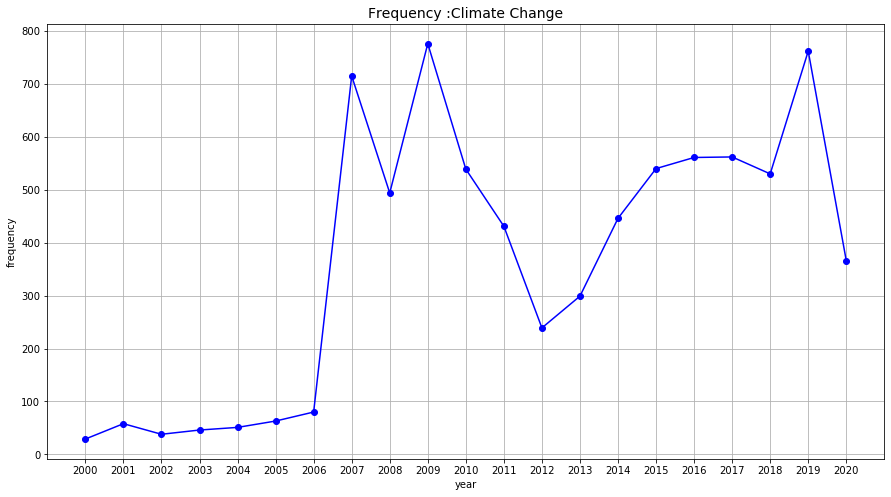

In [26]:
#1)Create frequency dictionary
freq_climate={}
for i in data:
    freq_bigram(data[i],'climate','change')
    freq_climate.update({i:counts})


#2)Draw a frequency plot
freq_plot(freq_climate,'Climate Change')

# Compare 2 graphs

In [86]:
#tokens=data['2000']+data['2001']+data['2002']+data['2003']+data['2004']+data['2005']+data['2006']

In [101]:
year1='2007'
year2='2019'
word='climate'

In [102]:
freq(data[year1],word,50)
concor_before=cc
co_mat(cc,freq_list)
before_df=df

freq(data[year2],word,50)
concor_after=cc
co_mat(cc,freq_list)
after_df=df

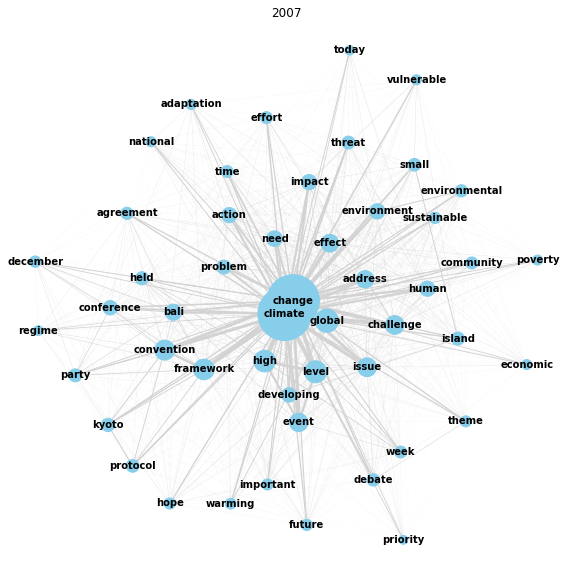

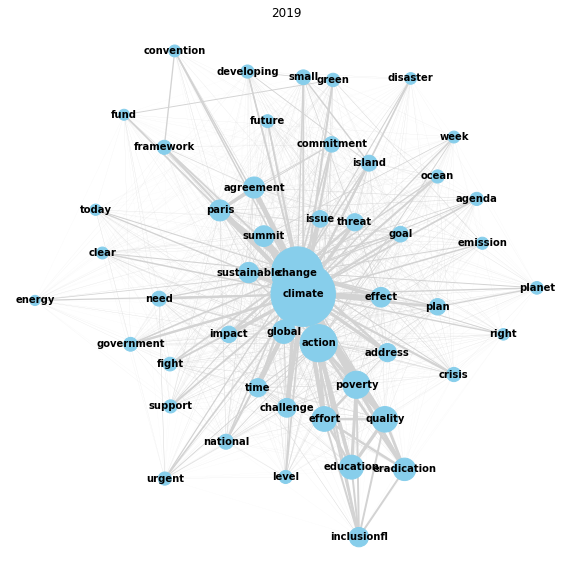

In [103]:
#3) Draw concordance network
draw_plot(before_df,year1)
before_G=G
node_size_before=node_sizes

graph_info(G)
before_info=df_info


draw_plot(after_df,year2)
after_G=G
node_size_after=node_sizes

graph_info(G)
after_info=df_info

In [104]:
#4) Similarity info
print("Total edges in the Graph",year1,":",len(before_info))
print("Total edges in the Graph",year2,":",len(after_info))

#total edges
k=pd.merge(before_info,after_info,on=["node1","node2"],how="outer")
k=k.fillna(0)
common_edges=k[(k["weight_x"]>0) & (k["weight_y"]>0)]
print("The number of common edges:",len(common_edges))

before_node=before_df.index.tolist()
after_node=after_df.index.tolist()
print("Total nodes in the Graph ",year1,":",len(before_node))
print("Total nodes in the Graph ",year2,":",len(after_node))
def Intersection(lst1, lst2):
    return set(lst1).intersection(lst2)

intersection_nodes=Intersection(before_node, after_node)
print("The number of common nodes :", len(intersection_nodes))


before_set=list(set(before_node)-set(intersection_nodes))
after_set=list(set(after_node)-set(intersection_nodes))

common_edges=k[(k["weight_x"]>0) & (k["weight_y"]>0)]
before_edges=k[(k["weight_x"]>0) & (k["weight_y"]==0)]
after_edges=k[(k["weight_x"]==0) & (k["weight_y"]>0)]



#Jaccard similarity : [JaccardDist(nodes) / (1 + edgeCount)]
#edgeCount = the number of common edges
#JaccardDist(node) = intersection of nodes/union of nodes
jac_dist=1-(len(intersection_nodes)/(len(before_node)+len(after_node)-len(intersection_nodes)))
print("Jaccard distance:",jac_dist)
jac_sim=jac_dist/(1+len(common_edges))
print("Jaccard similarity(=jac_dist/(1+len(common_edges)):",jac_sim)

Total edges in the Graph 2007 : 880
Total edges in the Graph 2019 : 946
The number of common edges: 241
Total nodes in the Graph  2007 : 50
Total nodes in the Graph  2019 : 50
The number of common nodes : 26
Jaccard distance: 0.6486486486486487
Jaccard similarity(=jac_dist/(1+len(common_edges)): 0.002680366316729953


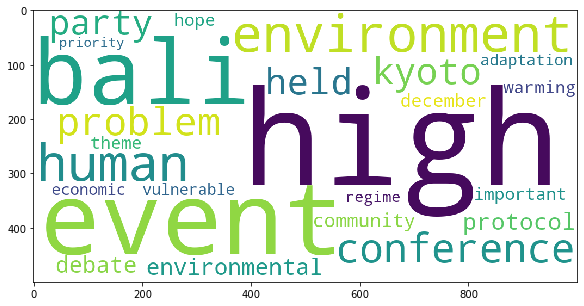

In [105]:
before_only_freq={}
for i in before_set:
    before_only_freq.update({i:node_size_before[i]})
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate_from_frequencies(before_only_freq)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud)

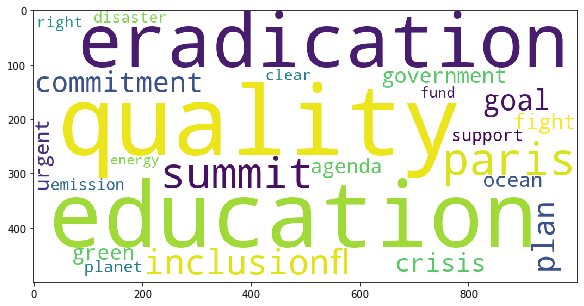

In [106]:

after_only_freq={}
for i in after_set:
    after_only_freq.update({i:node_size_after[i]})
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate_from_frequencies(after_only_freq)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud)

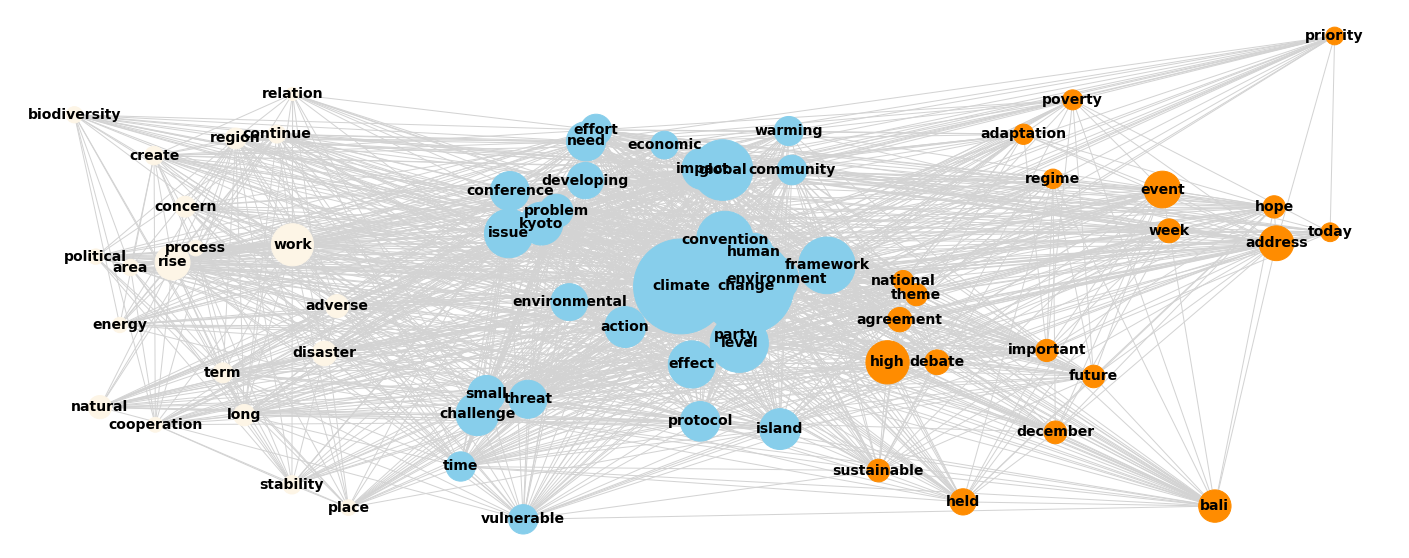

In [100]:
import random
plt.subplots(figsize=(25,10)) 
G=nx.from_pandas_edgelist(k, 'node1', 'node2')

pos = nx.spring_layout(G, k=0.2, iterations=5)

a=list(G.edges)

# #node size
# node_sizes={}
# for node in G:
#     w=node_sizes_2007[node]+node_sizes_2006[node]
#     node_sizes.update({i:w})  
node_sizes={}
color_map = []
shape=[]
for node in G:
    w=0
    if node == 'climate':
        color_map.append('skyblue')  
        pos[node][0]=-0.05
        pos[node][1]=0
        w=node_size_before[node]+node_size_after[node]
    elif node == 'change':
        color_map.append('skyblue')  
        pos[node][0]=0.05
        pos[node][1]=0
        w=node_size_before[node]+node_size_after[node]
    elif node in before_set:
        color_map.append('oldlace')
        pos[node][0]=random.uniform(-1, -0.45)
        w=node_size_before[node]
    elif node in after_set: 
        color_map.append('darkorange')
        pos[node][0]=random.uniform(0.25, 1)
        w=node_size_after[node]
    else: 
        color_map.append('skyblue')  
        pos[node][0]=random.uniform(-0.4, 0.2)
        w=node_size_before[node]+node_size_after[node]
    node_sizes.update({node:w})

#pos=nx.get_node_attributes(G,'pos')
nx.draw(G, pos, node_color=color_map,node_size=[min(9000,v*2) for v in node_sizes.values()],font_size=14, edge_color='lightgrey',font_weight = 'bold', with_labels=True)
plt.show()

In [107]:
before_set
text=""
for i in before_set:
    text=text+i+" "
print(text)
blob = TextBlob(text)
blob.sentiment

vulnerable december environmental party debate conference adaptation environment human hope priority warming bali event community problem theme kyoto held economic regime high important protocol 


Sentiment(polarity=0.052000000000000005, subjectivity=0.46799999999999997)

In [108]:
after_set
text=""
for i in after_set:
    text=text+i+" "
print(text)
blob = TextBlob(text)
blob.sentiment

clear support education commitment summit crisis ocean paris disaster government goal eradication green agenda right inclusionﬂ planet fight fund emission energy urgent plan quality 


Sentiment(polarity=0.06190476190476191, subjectivity=0.4063492063492064)